In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import time
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

cleaned = pd.read_csv('../data/cleaned_train_data.csv')
cleaned_test = pd.read_csv('../data/cleaned_test_data.csv')
cleaned['C_SEV'].value_counts()

FileNotFoundError: [Errno 2] File b'../data/cleaned_train_data.csv' does not exist: b'../data/cleaned_train_data.csv'

In [ ]:
cleaned['C_SEV'].value_counts()

In [ ]:
# Separate majority and minority classes
majority = cleaned[cleaned.C_SEV==2]
minority = cleaned[cleaned.C_SEV==1]

# downsample majority class
maj_downsampled = resample(majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2559, # to match majority class
                                 random_state=407) # reproducible results
 
# Combine majority class with upsampled minority class
resampled = pd.concat([minority, maj_downsampled])
 
# Display new class counts
resampled['C_SEV'].value_counts()

In [ ]:
X_train = resampled.drop(['C_SEV'], axis = 1)
y_train = resampled['C_SEV']
X_test = cleaned_test.drop(['C_SEV'], axis = 1)
y_test = cleaned_test['C_SEV']

In [ ]:
categorical_features = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN',
       'C_TRAF', 'V_TYPE']
categorical_transformer = Pipeline(steps=[
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

preprocessor = ColumnTransformer(
                                 transformers=[
                                    ('cat', categorical_transformer, categorical_features)
                                ])

In [ ]:
### parameter tuning 

In [ ]:
# rf_params = [{
#     'classifier' : [RandomForestClassifier()],
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_features' : list(range(6,32,5))}]

# rf_model = { 'Random Forest': RandomForestClassifier()}

In [ ]:
# log_params = [{'classifier' : [LogisticRegression()],
#     'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']}]

# log_model = { 'Logistic Regression': LogisticRegression()}

In [ ]:
# pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', LogisticRegression())])
# search = GridSearchCV(pipe, log_params,
#                       n_jobs=-1,
#                       scoring = "accuracy",
#                       cv = 5,
#                       refit = True)
# search.fit(X_train, y_train)
# tr_err = 1 - search.score(X_train, y_train)
# valid_err = 1 - search.score(X_test, y_test)
# results_dict['Logistic Regression'] = [round(tr_err,3), round(valid_err,3), search.best_params_]

In [ ]:
# pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', RandomForestClassifier())])
# search = GridSearchCV(pipe, rf_params,
#                       n_jobs=-1,
#                       scoring = "accuracy",
#                       cv = 5,
#                       refit = True)
# search.fit(X_train, y_train)
# tr_err = 1 - search.score(X_train, y_train)
# valid_err = 1 - search.score(X_test, y_test)
# results_dict['Random Forest'] = [round(tr_err,3), round(valid_err,3), search.best_params_]

In [ ]:
# pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', LogisticRegression())])

# search = GridSearchCV(pipe, log_params,
#                       n_jobs=-1,
#                       scoring = "accuracy",
#                       cv = 5,
#                       refit = True)
# search.fit(X_train, y_train)
# tr_err = 1 - search.score(X_train, y_train)
# valid_err = 1 - search.score(X_test, y_test)
# results_dict['Logistic Regression'] = [round(tr_err,3), round(valid_err,3), search.best_params_]

In [163]:
results_dict = dict()

In [164]:
# results = pd.DataFrame(results_dict).T
# results.columns = ("Train Score", "Validation Score", "Best Parameters")
# results

In [165]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None,
                          criterion='gini', max_depth=None, max_features=6,
                          max_leaf_nodes=None, 
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0,
                          n_jobs=None, oob_score=False, random_state=None,
                          verbose=0, warm_start=False))])
rf = pipe.fit(X_train, y_train)
tr_err = 1 - rf.score(X_train, y_train)
valid_err = 1 - rf.score(X_test, y_test)
results_dict['Random Forest'] = [round(tr_err,3), round(valid_err,3)]


C:\Users\vigne\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [166]:
confusion_matrix_rf_train = confusion_matrix(y_train, pipe.predict(X_train))
confusion_matrix_rf_test = confusion_matrix(y_test, pipe.predict(X_test))
report_rf = classification_report(y_train, pipe.predict(X_train), output_dict = True)

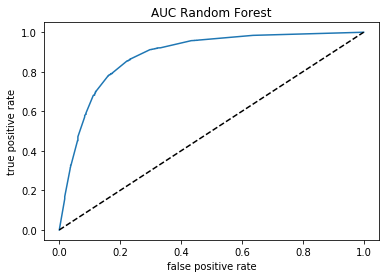

In [167]:
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:,1], pos_label=2)

plt.plot(fpr, tpr);
plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.title('AUC Random Forest');
plt.savefig('../results/auc_rf.png')

In [168]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
                      fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                      max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                      warm_start=False))])

In [169]:
log = pipe.fit(X_train, y_train)
tr_err = 1 - log.score(X_train, y_train)
valid_err = 1 - log.score(X_test, y_test)
results_dict['Log'] = [round(tr_err,3), round(valid_err,3)]

In [170]:
pd.DataFrame(results_dict, index = ['Train', 'Test']).to_csv("../results/errors.csv")
print("Both models were run and the error file has been generated")

Both models were run and the error file has been generated


In [171]:
confusion_matrix_lgr_train = confusion_matrix(y_train, pipe.predict(X_train))
confusion_matrix_lgr_test = confusion_matrix(y_test, pipe.predict(X_test))
report_lr = classification_report(y_train, pipe.predict(X_train), output_dict = True)

print("Generated confusion matrices for test and train")
print("Generated classification report for training data")

Generated confusion matrices for test and train
Generated classification report for training data


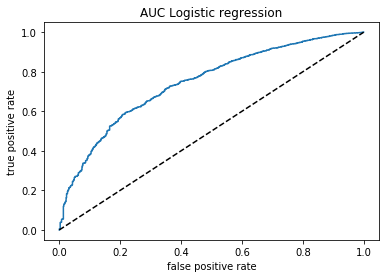

In [172]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:,1], pos_label=2)

plt.plot(fpr, tpr);
plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.title('AUC Logistic regression');
plt.savefig('../results/auc_lgr.png')

In [173]:
confusion_matrix_lgr_train

array([[1781,  778],
       [ 732, 1827]], dtype=int64)

In [174]:
confusion_matrix_rf_train

array([[2508,   51],
       [  85, 2474]], dtype=int64)

In [175]:
confusion_matrix_lgr_test

array([[  446,   225],
       [13900, 30963]], dtype=int64)

In [176]:
confusion_matrix_rf_test

array([[  590,    81],
       [13393, 31470]], dtype=int64)

In [177]:
report_lr

{'1': {'precision': 0.7087146836450458,
  'recall': 0.6959749902305589,
  'f1-score': 0.7022870662460569,
  'support': 2559},
 '2': {'precision': 0.7013435700575815,
  'recall': 0.7139507620164126,
  'f1-score': 0.7075910147172734,
  'support': 2559},
 'accuracy': 0.7049628761234857,
 'macro avg': {'precision': 0.7050291268513136,
  'recall': 0.7049628761234857,
  'f1-score': 0.7049390404816651,
  'support': 5118},
 'weighted avg': {'precision': 0.7050291268513136,
  'recall': 0.7049628761234857,
  'f1-score': 0.7049390404816651,
  'support': 5118}}

In [178]:
print(report_rf)

{'1': {'precision': 0.9672194369456228, 'recall': 0.9800703399765534, 'f1-score': 0.9736024844720497, 'support': 2559}, '2': {'precision': 0.9798019801980198, 'recall': 0.9667838999609223, 'f1-score': 0.973249409913454, 'support': 2559}, 'accuracy': 0.9734271199687378, 'macro avg': {'precision': 0.9735107085718213, 'recall': 0.9734271199687379, 'f1-score': 0.9734259471927518, 'support': 5118}, 'weighted avg': {'precision': 0.9735107085718213, 'recall': 0.9734271199687378, 'f1-score': 0.9734259471927519, 'support': 5118}}


In [179]:
df_rf_classification = pd.DataFrame(report_rf)
df_rf_classification.to_csv('../results/rf_classification.csv')

df_rf_classification = pd.DataFrame(report_lr)
df_rf_classification.to_csv("../results/lgr_classification.csv")

In [180]:
confusion_matrix_lgr_train_df = pd.DataFrame(confusion_matrix_lgr_train, 
                                             index = ['Not fatal', 'Fatal'],
                                             columns=['Not fatal', 'Fatal'])
confusion_matrix_lgr_train_df.to_csv('../results/lgr_train_confusion.csv')

In [181]:
confusion_matrix_lgr_test_df = pd.DataFrame(confusion_matrix_lgr_test, 
                                             index = ['Not fatal', 'Fatal'],
                                             columns=['Not fatal', 'Fatal'])
confusion_matrix_lgr_test_df.to_csv('../results/lgr_test_confusion.csv')

In [182]:
confusion_matrix_rf_train_df = pd.DataFrame(confusion_matrix_rf_train, 
                                             index = ['Not fatal', 'Fatal'],
                                             columns=['Not fatal', 'Fatal'])
confusion_matrix_rf_train_df.to_csv('../results/rf_train_confusion.csv')

In [183]:
confusion_matrix_rf_test_df = pd.DataFrame(confusion_matrix_rf_test, 
                                             index = ['Not fatal', 'Fatal'],
                                             columns=['Not fatal', 'Fatal'])
confusion_matrix_rf_test_df.to_csv('../results/rf_test_confusion.csv')